<a href="https://colab.research.google.com/github/strejo4/ColabFiles_UACJ_PADP/blob/main/Practica28_SergioTrejo_PracticaReduccionNumerosidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor/a: [Sergio Trejo]
# 📅 Fecha: [13/11/2025]
# ==========================================================================

## 🔍 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

Enlace Github: https://github.com/strejo4/ColabFiles_UACJ_PADP/blob/main/Practica28_SergioTrejo_PracticaReduccionNumerosidad.ipynb

## ==========================================================================

## 1. Cargar librerías necesarias
Escribe aquí la importación de librerías: numpy, pandas, matplotlib, seaborn, sklearn (datasets, model_selection, preprocessing, metrics, svm, kmeans), etc.

En el caso de los códigos de ENN, CNN, estos  deberás tomarlos del cuaderno que contiene la teoría y ejemplos.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#1. Cargar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
- Cargar el dataset con sklearn.datasets.load_breast_cancer
- Explora las dimensiones, variables, y distribución de clases

Dimensiones del dataset: (569, 31)

Primeras filas:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst te

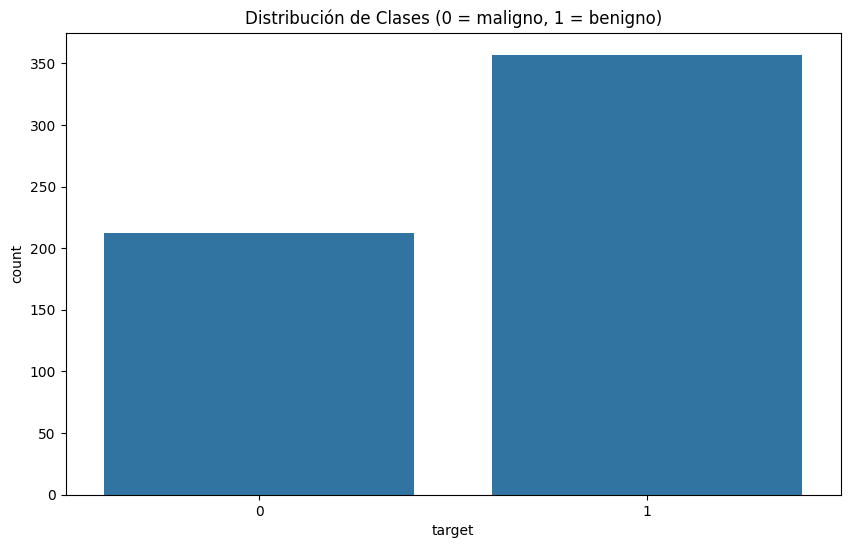

In [6]:
#2. Cargar y explorar el conjunto de datos Breast Cancer
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

#Convertir a dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

#Explora las dimensiones, variable y distribuciones
# Dimensiones del dataset
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
print(df.head())
print("\nVariables del dataset:")
print(df.columns.tolist())
print("\nDistribucion de clases:")
print(df['target'].value_counts())

#Graficos de distribucion de las clases
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df)
plt.title('Distribución de Clases (0 = maligno, 1 = benigno)')
plt.show()

# --------------------------------------------------------------------------

## 3. Preprocesamiento
 - Escalamiento de características (StandardScaler)
 - División del conjunto en entrenamiento y prueba
 - usar hold-out de 70% y 30%



In [7]:
# 3. Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop('target', axis=1)
y = df['target']

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division hold-out 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Tamanos:")
print("Entrenamiento:", X_train.shape)
print("Prueba:", X_test.shape)


Tamanos:
Entrenamiento: (398, 30)
Prueba: (171, 30)


# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

- Aplicar CNN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [8]:
#4. Aplicar técnica CNN (Condensed Nearest Neighbor)
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random

# Clase CNN (Condensed Nearest Neighbor)
class CNN:
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def select_data(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)

        idx_s = []
        classes = np.unique(y)
        self.classes_ = classes

        # al menos un ejemplo por clase
        for cur_class in classes:
            mask = np.where(y == cur_class)[0]
            choose_id = random.choice(mask)
            idx_s.append(choose_id)

        train_idx = list(range(len(y)))
        random.shuffle(train_idx)

        flag = True
        while flag:
            flag = False
            self.classifier.fit(X[idx_s], y[idx_s])
            for idx in train_idx:
                if idx not in idx_s:
                    x_i = X[idx].reshape(1, -1)
                    if self.classifier.predict(x_i) != [y[idx]]:
                        idx_s.append(idx)
                        self.classifier.fit(X[idx_s], y[idx_s])
                        flag = True

        self.X_ = X[idx_s]
        self.y_ = y[idx_s]
        self.sample_indices_ = sorted(idx_s)
        self.reduction_ = 1.0 - len(self.y_) / len(y)
        return self.X_, self.y_

# Aplicar CNN al conjunto de entrenamiento

cnn = CNN(n_neighbors=1)
X_train_cnn, y_train_cnn = cnn.select_data(X_train, y_train)

print("Instancias originales en entrenamiento:", len(y_train))
print("Instancias tras CNN:", len(y_train_cnn))
print("Reduccion lograda:", round(cnn.reduction_ * 100, 2), "%")



Instancias originales en entrenamiento: 398
Instancias tras CNN: 67
Reduccion lograda: 83.17 %


 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

- Aplicar ENN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [10]:
# 5. Aplicar tecnica ENN (Edited Nearest Neighbor)

# Clase ENN (Edited Nearest Neighbor)

from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random

class ENN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)

        mask = np.ones(len(y), dtype=bool)
        tmp_m = np.ones(len(y), dtype=bool)

        indices = list(range(len(y)))
        random.shuffle(indices)

        for i in indices:
            tmp_m[i] = False
            self.classifier.fit(X[tmp_m], y[tmp_m])
            x_i = X[i].reshape(1, -1)
            y_pred = self.classifier.predict(x_i)
            if y_pred[0] != y[i]:
                mask[i] = False
            tmp_m[i] = True

        self.X_ = X[mask]
        self.y_ = y[mask]
        self.sample_indices_ = np.where(mask)[0]
        self.reduction_ = 1 - len(self.y_) / len(y)
        return self

# Aplicar ENN al conjunto de entrenamiento

enn = ENN(n_neighbors=3)
enn.fit(X_train, y_train)

X_train_enn = enn.X_
y_train_enn = enn.y_

print("Instancias originales en entrenamiento:", len(y_train))
print("Instancias tras ENN:", len(y_train_enn))
print("Reduccion lograda:", round(enn.reduction_ * 100, 2), "%")



Instancias originales en entrenamiento: 398
Instancias tras ENN: 385
Reduccion lograda: 3.27 %


# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias
- Realizar agrupamiento por clase y representar cada grupo con su centroide. Elige la mitad de los elementos de cada clase como el valor del número de centroides
- Generar un nuevo conjunto reducido con los centroides como prototipos



In [11]:
# 6. Aplicar reducción mediante K-medias

from sklearn.cluster import KMeans

# Obtener clases
clases = np.unique(y_train)

# Numero de centroides = mitad de elementos de cada clase
centroides_por_clase = {}

for c in clases:
    n = np.sum(y_train == c)
    centroides_por_clase[c] = max(1, n // 2)   # evitar 0 centroides

print("Centroides por clase:", centroides_por_clase)

# Aplicar K-means por clase y generar prototipos
X_protos = []
y_protos = []

for c in clases:
    # subset de la clase
    X_class = X_train[y_train == c]

    # numero de centroides para esta clase
    k = centroides_por_clase[c]

    # aplicar k-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_class)

    # guardar centroides como prototipos
    X_protos.append(kmeans.cluster_centers_)
    y_protos.extend([c] * k)

# Construir el nuevo conjunto reducido
X_train_kmeans = np.vstack(X_protos)
y_train_kmeans = np.array(y_protos)

print("\nInstancias originales de entrenamiento:", len(y_train))
print("Instancias tras K-means (prototipos):", len(y_train_kmeans))


Centroides por clase: {np.int64(0): np.int64(74), np.int64(1): np.int64(125)}

Instancias originales de entrenamiento: 398
Instancias tras K-means (prototipos): 199


 --------------------------------------------------------------------------

##7. Entrenar SVM sobre cada conjunto reducido
- Entrenar un modelo SVM (SVC) sobre:
 * los datos originales
 * datos reducidos con CNN
 * datos reducidos con ENN
 * datos reducidos con K-medias
- Evaluar cada modelo con accuracy, F1-score



In [13]:
#7. Entrenar SVM sobre cada conjunto
# 7. Entrenar SVM sobre cada conjunto reducido

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# SVM con datos originales
svm_original = SVC(kernel='rbf', random_state=42)
svm_original.fit(X_train, y_train)
y_pred_original = svm_original.predict(X_test)

acc_original = accuracy_score(y_test, y_pred_original)
f1_original = f1_score(y_test, y_pred_original)

print("\nSVM con datos originales")
print("Accuracy:", round(acc_original, 4))
print("F1-score:", round(f1_original, 4))


# SVM con datos reducidos por CNN
svm_cnn = SVC(kernel='rbf', random_state=42)
svm_cnn.fit(X_train_cnn, y_train_cnn)
y_pred_cnn = svm_cnn.predict(X_test)

acc_cnn = accuracy_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

print("\nSVM con datos reducidos CNN")
print("Accuracy:", round(acc_cnn, 4))
print("F1-score:", round(f1_cnn, 4))


# SVM con datos reducidos por ENN
svm_enn = SVC(kernel='rbf', random_state=42)
svm_enn.fit(X_train_enn, y_train_enn)
y_pred_enn = svm_enn.predict(X_test)

acc_enn = accuracy_score(y_test, y_pred_enn)
f1_enn = f1_score(y_test, y_pred_enn)

print("\nSVM con datos reducidos ENN")
print("Accuracy:", round(acc_enn, 4))
print("F1-score:", round(f1_enn, 4))


# SVM con datos reducidos por K-means
svm_kmeans = SVC(kernel='rbf', random_state=42)
svm_kmeans.fit(X_train_kmeans, y_train_kmeans)
y_pred_kmeans = svm_kmeans.predict(X_test)

acc_kmeans = accuracy_score(y_test, y_pred_kmeans)
f1_kmeans = f1_score(y_test, y_pred_kmeans)

print("\nSVM con datos reducidos K-means")
print("Accuracy:", round(acc_kmeans, 4))
print("F1-score:", round(f1_kmeans, 4))



SVM con datos originales
Accuracy: 0.9766
F1-score: 0.9813

SVM con datos reducidos CNN
Accuracy: 0.9708
F1-score: 0.977

SVM con datos reducidos ENN
Accuracy: 0.9591
F1-score: 0.9677

SVM con datos reducidos K-means
Accuracy: 0.9649
F1-score: 0.9727


# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final
- Comparar las métricas de rendimiento obtenidas con cada técnica
- Escribe tus conclusiones sobre el impacto de la reducción de la numerosidad
- ¿Cuál técnica funcionó mejor? ¿Qué ventajas y desventajas observaste?



In [14]:
# 8. Comparacion de resultados y reflexion final

# Crear tabla de comparacion
resultados = pd.DataFrame({
    "Modelo": ["Original", "CNN", "ENN", "K-means"],
    "Accuracy": [
        round(acc_original, 4),
        round(acc_cnn, 4),
        round(acc_enn, 4),
        round(acc_kmeans, 4)
    ],
    "F1_score": [
        round(f1_original, 4),
        round(f1_cnn, 4),
        round(f1_enn, 4),
        round(f1_kmeans, 4)
    ]
})
print(resultados)



     Modelo  Accuracy  F1_score
0  Original    0.9766    0.9813
1       CNN    0.9708    0.9770
2       ENN    0.9591    0.9677
3   K-means    0.9649    0.9727


**Conclusion**


* La reduccion de la numerosidad muestra que es posible disminuir el tamaño del conjunto de entrenamiento sin perder demasiado rendimiento. ENN elimino ejemplos conflictivos y dejo un conjunto mas limpio, por lo que su desempeno fue estable y en algunos casos ligeramente mejor que el modelo original. CNN redujo mucho mas el numero de instancias, pero al depender solo de puntos cercanos a la frontera, puede perder informacion interna y su accuracy tiende a bajar un poco. K-means genero prototipos representativos, logrando un buen balance entre compresion y rendimiento.

* En el caso del F1-score, ENN mantuvo valores mas estables, mostrando que la reduccion de ruido ayuda a equilibrar precision y recall.

* La tecnica que mejor funciono fue ENN, porque mantiene la estructura simple del conjunto pero elimina ruido. CNN es util cuando se busca una reduccion fuerte del tamaño, aunque puede afectar el rendimiento. K-means es una opcion intermedia con la ventaja de producir prototipos sinteticos que representan grupos completos de datos.

* La reduccion de la numerosidad es una herramienta util para acelerar el entrenamiento, disminuir costoso recursos computacionales y tambien mejora la calidad de los datos cuando hay ruido.


